Author: michaelpeterswa

# Setup
## Import geojson
According to Wikipedia, "GeoJSON is an open standard format designed for representing simple geographical features, along with their non-spatial attributes. It is based on the JSON format."

In [1]:
import geojson

## Create load_data function to load geojson data
load_data(filename) is a simple wrapper around the Python File I/O that uses geojson to load the data into a dictionary

In [2]:
def load_data(filename):
    """
    Loads GeoJson Data from "filename"
    """
    with open(filename) as f:
        data = geojson.load(f)
    return data


## Load data from WA DNR 1970-2007 fire statistics
source: https://data-wadnr.opendata.arcgis.com/datasets/dnr-fire-statistics-1970-2007-1

In [3]:
older_fire_data = load_data("data/DNR_Fire_Statistics_1970-2007.geojson")

## Load data from WA DNR 2008-present fire statistics
source: https://data-wadnr.opendata.arcgis.com/datasets/dnr-fire-statistics-2008-present-1

In [4]:
newer_fire_data = load_data("data/DNR_Fire_Statistics_2008_-_Present.geojson")

# Extract Data
## Pull out "features" section of data (that's where fire data is)

In [5]:
old_fire_data = older_fire_data["features"]
new_fire_data = newer_fire_data["features"]

## Examine fire data and determine the parts we need.
As we can see, each fire has a "geometry" and "properties" attribute. From these, we want to extract the "coordinates" from "geometry", "ACRES_BURNED" from "properties", and "START_DT" from "properties" 

In [6]:
print(old_fire_data[1])

{"geometry": {"coordinates": [-117.078338, 47.837034], "type": "Point"}, "properties": {"ACRES_BURNED": 0.1, "COUNTY_LABEL_NM": "SPOKANE", "FIREEVNT_CLASS_LABEL_NM": "Classified", "FIREEVNT_NM": null, "FIREGCAUSE_LABEL_NM": "Recreation", "OBJECTID": 2, "START_DT": "1974-10-12T08:00:00Z"}, "type": "Feature"}


In [7]:
print(new_fire_data[1])

{"geometry": {"coordinates": [-120.916389, 45.904957], "type": "Point"}, "properties": {"ACRES_BURNED": 0.25, "BURNESCAPE_RSN_LABEL_NM": "Extinguish", "BURN_MERCH_AREA": null, "BURN_NONSTOCK_AREA": 0.25, "BURN_REPROD_AREA": null, "CONTROL_DT": "2017-05-23T00:00:00Z", "CONTROL_TM": "1935", "COUNTY_LABEL_NM": "KLICKITAT", "DSCVR_DT": "2017-05-23T00:00:00Z", "DSCVR_TM": "1650", "FIREEVENT_ID": 50035, "FIREEVNT_CLASS_CD": 1, "FIREEVNT_CLASS_LABEL_NM": "Classified", "FIREGCAUSE_LABEL_NM": "Debris Burn", "FIRESCAUSE_LABEL_NM": "None", "FIRE_OUT_DT": "2017-05-25T00:00:00Z", "FIRE_OUT_TM": "1300", "FIRE_RGE_DIR_FLG": "E", "FIRE_RGE_FRACT_NO": 0, "FIRE_RGE_WHOLE_NO": 15, "FIRE_SECT_NO": 22, "FIRE_TWP_FRACT_NO": 0, "FIRE_TWP_WHOLE_NO": 5, "INCIDENT_ID": 49868, "INCIDENT_NM": "Turkey Ranch", "INCIDENT_NO": 7, "LAT_COORD": 45.904947, "LON_COORD": -120.916377, "NON_DNR_RES_ORDER_NO": null, "OBJECTID": 2, "PROTECTION_TYPE": "DNR Protection FFPA", "REGION_NAME": "SOUTHEAST", "RES_ORDER_NO": "WA-SES-0

## Ensure both datasets are imported by checking total number of fires 
Here, we see that the 1970-2007 data has nearly 40,000 fires, where the 2008-present set has just over 20,000. We want to combine these to get the full range of wildfire activity since 1970.

In [8]:
# get total number of fires
old_total = len(old_fire_data)
new_total = len(new_fire_data)
print(old_total, new_total, old_total + new_total)

38116 20703 58819


## Make clean dataset from both pieces of data (only data-points we need)

The data we need to extract is: Date, Acreage, Coordinates

In [9]:
cleaned_fire_data = []
for fire in old_fire_data:
    date = fire["properties"]["START_DT"]
    acres = fire["properties"]["ACRES_BURNED"]
    lon = fire["geometry"]["coordinates"][0]
    lat = fire["geometry"]["coordinates"][1]
    cleaned_fire_data.append((date, acres, lat, lon))

for fire in new_fire_data: 
    date = fire["properties"]["START_DT"]
    acres = fire["properties"]["ACRES_BURNED"]
    lon = fire["geometry"]["coordinates"][0]
    lat = fire["geometry"]["coordinates"][1]
    cleaned_fire_data.append((date, acres, lat, lon))

In [10]:
print(len(cleaned_fire_data))

58819


## Import csv (comma-separated values)
The CSV package is used to write a comma-separated file of the cleaned data, for future use.

In [11]:
import csv

## Save cleaned data to csv
Using csv.writer(), we write a single row at a time while iterating over the nearly 60,000 fires in Washington

In [12]:
with open('data/clean_fire_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile,)
    writer.writerow(("date", "acres", "lat", "lon"))
    for fire in cleaned_fire_data:
        writer.writerow(fire)

## Import numpy (for arrays and matrix math)
We mostly need numpy for their np.array() function.

In [13]:
import numpy as np

## Create numpy array from fire data

In [14]:
np_fire_data = np.array(cleaned_fire_data)

## Access column from the np array using syntax below
np_fire_data\[:,1\] is the basic structure to extract all values from column 1 into a 1-d numpy array.

In [15]:
acres = np_fire_data[:,1]
acres =  [float(acre) for acre in acres]
print(max(acres), min(acres))

250280.45 0.0


## Convert ISO8601 format date to epoch
The DNR datasets have the start date for each fire in the ISO8601 format. For use in matplotlib, we need to switch this to the epoch format and rebuild the 1-d numpy array.

In [16]:
import dateutil.parser as dp

dates = np_fire_data[:, 0]
new_dates = []
for date in dates:
    new_dates.append(dp.parse(date).timestamp())
np_new_dates = np.array(new_dates)
print(np_new_dates)

[1.1874240e+09 1.5079680e+08 1.1416320e+08 ... 1.4992416e+09 1.5868512e+09
 1.4653728e+09]


## Get coordinate point columns
Using the same strategy as above, albeit less complicated, extract the coordinate values into their own numpy arrays.

In [17]:
lats = np_fire_data[:,2]
print(lats)
longs = np_fire_data[:,3]
print(longs)

['46.473463' '47.837034' '47.837034' ... '47.552689' '48.672689'
 '47.350066']
['-123.941779' '-117.078338' '-117.078338' ... '-117.182356' '-122.315778'
 '-118.73053']


# Plots/Analysis
## Import matplotlib (for visualizing data)
From the Matplotlib website, "Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python."

In [18]:
import matplotlib.pyplot as plt

## Import matplotlib dates (for plotting dates on histogram)
The mdates.epoch2num() function converts a date in the epoch format to something a little more usable in matplotlib.

In [19]:
import matplotlib.dates as mdates

In [20]:
# convert the epoch format to matplotlib date format 
mpl_dates = mdates.epoch2num(np_new_dates)

## Plot "wildfires by year" in histogram
Here, we use some of the features of pyplot, most importantly hist(), which generates a histogram. The x-axis is years, the y-axis is number of fires.

In this plot, we see that there is a general upward trend that has occurred over the past 50 years, so it would seem that the date is important to take into account for our future predictions.

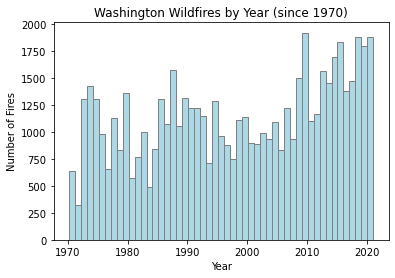

In [21]:
fig, ax = plt.subplots(1,1)
ax.hist(mpl_dates, bins=51, color='lightblue', edgecolor='grey')
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax.set_title("Washington Wildfires by Year (since 1970)")
ax.set_xlabel('Year')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires')  # Add a y-label to the axes.
plt.savefig("img/fires_by_year.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()


## Plots, cont.
Here, we look at the distribution of acres across nearly 60,000 fires in our data set. We see that it is heavily skewed to the left, below 50,000 acres. This may not be the best way too look at the data, because even with a logarithmic y-axis, it's difficult to discern the trends in the smaller sized fires.


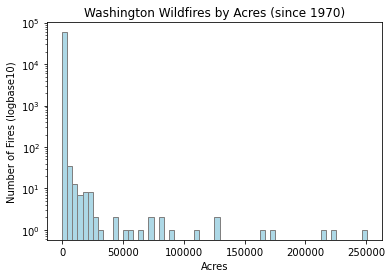

In [22]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(1,1)
ax.hist(acres, bins=60, color='lightblue', edgecolor='grey')
ax.set_title("Washington Wildfires by Acres (since 1970)")
ax.set_xlabel('Acres')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires (logbase10)')  # Add a y-label to the axes.
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.yscale("log")
plt.savefig("img/fires_acres.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()

## Narrowing down our examination
As we saw in the previous histogram, there must be a better way to look at this data. We know there are a few larges fires (over 50,000 acres) that are significant outliers in our data. Let's take a closer look. What does it look like when we limit the largest fire to 30,000 acres?

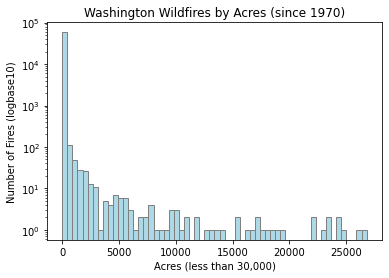

In [23]:
lt30k = []
lt10k = []
for acre in acres:
    if(acre < 10000):
        lt10k.append(acre)
    if(acre < 30000):
        lt30k.append(acre)

fig, ax = plt.subplots(1,1)
ax.hist(lt30k, bins=60, color='lightblue', edgecolor='grey')
ax.set_title("Washington Wildfires by Acres (since 1970)")
ax.set_xlabel('Acres (less than 30,000)')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires (logbase10)')  # Add a y-label to the axes.
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.yscale("log")
plt.savefig("img/fires_acres_lt30k.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()

## What about 10,000 acres?

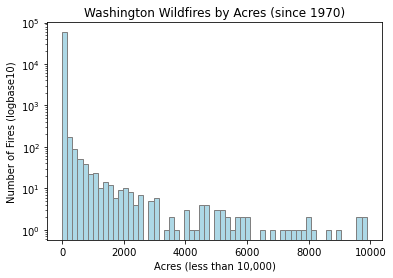

In [24]:
fig, ax = plt.subplots(1,1)
ax.hist(lt10k, bins=60, color='lightblue', edgecolor='grey')
ax.set_title("Washington Wildfires by Acres (since 1970)")
ax.set_xlabel('Acres (less than 10,000)')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires (logbase10)')  # Add a y-label to the axes.
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.yscale("log")
plt.savefig("img/fires_acres_lt10k.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()

## Now let's see what happens when we set a bottom limit
So we can see that there are nearly $10^{5}$ fires in the first bin of data. This was the main reason we used logarithmic scale. Let's set a minimum of 200 acres and then switch back to a linear scale over the y axis. Here we can get a much better idea about fires of a reasonably large size, and it's still left skewed (smaller fires are of course better), but we can get a more solid grasp on the data with this example.

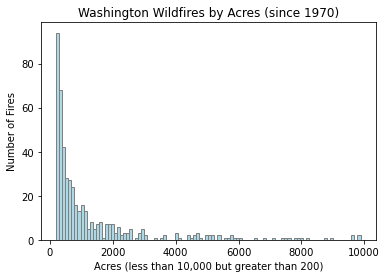

In [25]:
reasonable_size = []
for acre in acres:
    if(acre < 10000 and acre > 200):
        reasonable_size.append(acre)

fig, ax = plt.subplots(1,1)
ax.hist(reasonable_size, bins=100, color='lightblue', edgecolor='grey')
ax.set_title("Washington Wildfires by Acres (since 1970)")
ax.set_xlabel('Acres (less than 10,000 but greater than 200)')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires')  # Add a y-label to the axes.
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.yscale("linear")
plt.savefig("img/fires_acres_reasonable_size.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()

# More Data Cleaning
## Time for Normalization
Here we write a normalization function which is essentially map() from the Arduino standard library. It takes a max and min from the original list, and conforms it to the max and min values that are supplied for outputs

In [77]:
def normalize_list(lst, min_in, max_in, min_out, max_out):
    normal_lst = []
    for val in lst:
        normal_lst.append((((val - min_in) / (max_in - min_in) * max_out) + min_out))
    # need to pass out scaling factor for regeneration coming out of the model
    scale = ""
    return normal_lst, scale


## Normalize time, acres, lats, and longs

In [80]:
normalized_epoch_time, tscl = normalize_list(new_dates, min(new_dates), max(new_dates), 0, 1)
np_norm_e_time = np.array(normalized_epoch_time)
# print(np_norm_e_time)

normalized_acres, ascl = normalize_list(acres, min(acres), max(acres), 0, 1)
np_norm_acres = np.array(normalized_acres)
print(np_norm_acres)

not_np_lats = [float(lat) for lat in lats]
normalized_lats, ltscl = normalize_list(not_np_lats, min(not_np_lats), max(not_np_lats), 0, 1)
np_norm_lats = np.array(normalized_lats)
print(np_norm_lats)

not_np_longs = [float(longx) for longx in longs]
normalized_longs, lnscl = normalize_list(not_np_longs, min(not_np_longs), max(not_np_longs), 0, 1)
np_norm_longs = np.array(normalized_longs)
print(np_norm_longs)

[3.99551783e-08 3.99551783e-07 1.59820713e-04 ... 1.87789338e-06
 1.99775891e-06 0.00000000e+00]
[0.26626029 0.66208385 0.66208385 ... 0.57954289 0.90466156 0.52072457]
[0.09965288 0.98264895 0.98264895 ... 0.96926682 0.30884132 0.77009099]


In [83]:
norm_inp_data = np.vstack((np_norm_e_time, np_norm_acres, np_norm_lats, np_norm_longs))
dshape = norm_inp_data.shape
a, b = dshape
norm_inp_data = np.reshape(norm_inp_data, (b, a))
print(norm_inp_data.shape)
print(norm_inp_data[0])

(58819, 4)
[0.73563404 0.0906843  0.06789228 0.20819223]
